In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import roc_curve, roc_auc_score
import pandas as pd
from keras.preprocessing.image import ImageDataGenerator

import logging
logging.getLogger("tensorflow").setLevel(logging.ERROR)

2022-05-30 09:16:50.408865: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-05-30 09:16:50.408880: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


### Custom functions to facilitate testing process

In [2]:
# an Encoder object contains the classes for a classification problem; uses these keys to 
# either one-hot or sparse encode the labels of a dataset
class Encoder():
    def __init__(self, classes):
        self.classes = classes
        self.num_classes = len(classes)

    def one_hot(self, labels):
        output = np.zeros(shape=[len(labels), self.num_classes], dtype=int)
        for i, label in enumerate(labels):
            idx = np.where(self.classes == label)[0].item()
            output[i, idx] = 1

        return output

    def sparse(self, labels):
        output = np.empty_like(labels, dtype=int)
        for i, label in enumerate(labels):
            value = np.where(self.classes == label)[0].item()
            output[i, 0] = value
        return output

    def sparse_to_one_hot(self, labels):
        output = np.zeros(shape=[len(labels), self.num_classes], dtype=int)
        for i, label in enumerate(labels):
            idx = label
            output[i, idx] = 1

        return output

    def prediction_to_one_hot(self, predictions):
        output = np.zeros_like(predictions, dtype=int)
        idx = np.argmax(predictions, axis=1)
        for i in len(predictions):
            output[i, idx[i]] = 1
        return output


# creates the dataset and indicides for k-fold cross validation. 
# returns: 
#   pd.DataFrame with columns "feature" containing the path to the image file, 
#       and "label" containing that image's class
#   indices of DataFrame to be used each fold for testing
#   indices of DataFrame to be used each fold for testing
def k_fold_split(data_dir, folds):
    classes = os.listdir(data_dir)
    num_samples = sum([len(files) for r, d, files in os.walk(data_dir)])
    none_vec = [None for _ in range(num_samples)]
    ds = pd.DataFrame.from_dict({"features": none_vec, "labels": none_vec})

    i = 0
    for klass in classes:
        for file in os.listdir(os.path.join(data_dir, klass)):
            ds["features"].iat[i] = os.path.join(data_dir, klass, file)
            ds["labels"].iat[i] = klass
            i += 1
    del i

    skf = StratifiedKFold(n_splits=folds, shuffle=True, random_state=123)
    train_val_idxs = []
    test_idxs = []
    for train_val_idx, test_idx in skf.split(X=ds[["features"]], y=ds[["labels"]]):
        train_val_idxs.append(list(train_val_idx))
        test_idxs.append(list(test_idx))

    return ds, train_val_idxs, test_idxs



### Run the k-fold cross-validation

In [10]:
data_dir = '../../data_merged'  # directory with training, validation, and testing data
save_dir = '../../results/simple_cnn_full'  # directory to save testing results

batch_size = 32
img_height = 256
img_width = 256
channels = 3

folds = 10
epochs = 10

fit_gen_obj = ImageDataGenerator(horizontal_flip=True)  # object to create generators for training
eval_gen_obj = ImageDataGenerator(horizontal_flip=False)

ds, train_val_idxs, test_idxs = k_fold_split(data_dir, folds)
num_classes = len(np.array(sorted(os.listdir(data_dir), key=str.casefold)))

history = [None for _ in range(folds)]

for i in range(1, folds):
    train_val_paths = ds.iloc[train_val_idxs[i]]
    test_paths = ds.iloc[test_idxs[i]]

    train_paths, val_paths = train_test_split(train_val_paths, test_size=.1, random_state=123, stratify=train_val_paths[['labels']])

    print('fold %s started; loading training and validation data' % str(i + 1))
    train_input = fit_gen_obj.flow_from_dataframe(train_paths, x_col='features', y_col='labels', target_size=(img_height, img_width), class_mode='sparse',
                                                  color_mode='rgb', shuffle=True, batch_size=batch_size)
    val_input = eval_gen_obj.flow_from_dataframe(val_paths, x_col='features', y_col='labels', target_size=(img_height, img_width), class_mode='sparse',
                                                 color_mode='rgb', shuffle=True, batch_size=batch_size)

    print('reinitializing model')
    model = Sequential([
        layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
        layers.Conv2D(16, 3, padding='same', activation='relu'),
        layers.MaxPooling2D(),
        layers.Conv2D(32, 3, padding='same', activation='relu'),
        layers.MaxPooling2D(),
        layers.Conv2D(64, 3, padding='same', activation='relu'),
        layers.MaxPooling2D(),
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dense(num_classes)
    ])

    model.compile(optimizer='adam',
        loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
        metrics=['accuracy']
    )

    print('training')
    history[i] = model.fit(x=train_input, validation_data=val_input, epochs=epochs)

    print('loading test data')
    test_input = eval_gen_obj.flow_from_dataframe(test_paths, x_col='features', y_col='labels', target_size=(img_height, img_width), class_mode='sparse',
                                                  color_mode='rgb', shuffle=False, batch_size=batch_size)

    print('predicting')
    prediction = model.predict(test_input)
    
    print('saving')
    model.save(os.path.join(save_dir, 'models/model_' + str(i)))
    np.save(os.path.join(save_dir, 'predictions/prediction_%s.npy' % str(i)), prediction)
    np.save(os.path.join(save_dir, 'test_inputs/test_input_%s.npy' % str(i)), test_paths[['features']])
    np.save(os.path.join(save_dir, 'test_truths/test_truth_%s.npy' % str(i)), test_paths[['labels']])

    print("fold %s finished" % str(i + 1))
    del model
    print('****************************************')

fold 2 started; loading training and validation data
Found 67482 validated image filenames belonging to 38 classes.
Found 7499 validated image filenames belonging to 38 classes.
reinitializing model
training
Epoch 1/10
2109/2109 [==============================] - 849s 402ms/step - loss: 0.9845 - accuracy: 0.7081 - val_loss: 0.4753 - val_accuracy: 0.8508
Epoch 2/10
2109/2109 [==============================] - 802s 380ms/step - loss: 0.3269 - accuracy: 0.8974 - val_loss: 0.2655 - val_accuracy: 0.9172
Epoch 3/10
2109/2109 [==============================] - 798s 378ms/step - loss: 0.2134 - accuracy: 0.9311 - val_loss: 0.2458 - val_accuracy: 0.9239
Epoch 4/10
2109/2109 [==============================] - 802s 380ms/step - loss: 0.1486 - accuracy: 0.9525 - val_loss: 0.2089 - val_accuracy: 0.9405
Epoch 5/10
2109/2109 [==============================] - 801s 380ms/step - loss: 0.1189 - accuracy: 0.9614 - val_loss: 0.2260 - val_accuracy: 0.9361
Epoch 6/10
2109/2109 [==============================

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


Text(0.5, 1.0, 'Training and Validation Loss')

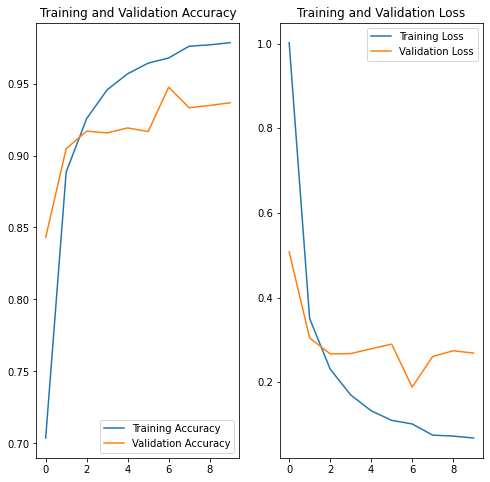

In [32]:
hist_idx = 5
print(history[hist_idx].history.keys())
acc = history[hist_idx].history['accuracy']
val_acc = history[hist_idx].history['val_accuracy']

loss = history[hist_idx].history['loss']
val_loss = history[hist_idx].history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')


In [4]:
classes = np.array(['Apple___Apple_scab', 'Apple___Black_rot', 'Apple___Cedar_apple_rust', 'Apple___healthy', 'Blueberry___healthy', 
                     'Cherry_(including_sour)___Powdery_mildew', 'Cherry_(including_sour)___healthy', 
                     'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot', 'Corn_(maize)___Common_rust_', 'Corn_(maize)___Northern_Leaf_Blight', 
                     'Corn_(maize)___healthy', 'Grape___Black_rot', 'Grape___Esca_(Black_Measles)', 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)', 
                     'Grape___healthy', 'Orange___Haunglongbing_(Citrus_greening)', 'Peach___Bacterial_spot', 'Peach___healthy', 
                     'Pepper,_bell___Bacterial_spot', 'Pepper,_bell___healthy', 'Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy', 
                     'Raspberry___healthy', 'Soybean___healthy', 'Squash___Powdery_mildew', 'Strawberry___Leaf_scorch', 'Strawberry___healthy', 
                     'Tomato___Bacterial_spot', 'Tomato___Early_blight', 'Tomato___Late_blight', 'Tomato___Leaf_Mold', 
                     'Tomato___Septoria_leaf_spot', 'Tomato___Spider_mites Two-spotted_spider_mite', 'Tomato___Target_Spot', 
                     'Tomato___Tomato_Yellow_Leaf_Curl_Virus', 'Tomato___Tomato_mosaic_virus', 'Tomato___healthy'])
encoder = Encoder(classes)

folds = 10

fprs = []  # d1 is class, d2 is rotation
tprs = []
thresholds = []

for i in range(len(classes)):
    fprs_temp = []
    tprs_temp = []
    thresholds_temp = []

    for j in range(folds):
        prediction_plot = np.load('../results/simple_cnn_full/predictions/prediction_%s.npy' % str(j))
        truth_plot = np.load('../results/simple_cnn_full/test_truths/test_truth_%s.npy' % str(j), allow_pickle=True)

        prediction_plot = tf.nn.softmax(prediction_plot)
        truth_plot = encoder.one_hot(truth_plot)

        fpr, tpr, threshold = roc_curve(truth_plot[:, i], prediction_plot[:, i])
        fprs_temp.append(fpr)
        tprs_temp.append(tpr)
        thresholds_temp.append(threshold)
    fprs.append(fprs_temp)
    tprs.append(tprs_temp)
    thresholds.append(thresholds_temp)

2022-05-30 09:21:57.634713: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-30 09:21:57.635150: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-05-30 09:21:57.635223: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2022-05-30 09:21:57.635279: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory
2022-05-30 09:21:57.635332: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Co

In [12]:
for class_num, klass in enumerate(classes):
    plt.xlabel('false positive rate')
    plt.ylabel('true positive rate')
    for i in range(folds):    
        plt.plot(fprs[class_num][i], tprs[class_num][i])
        plt.savefig('../results/simple_cnn_full/images/%s_auc' % klass)
    plt.clf()

<Figure size 432x288 with 0 Axes>

In [7]:
aucs = []

for i in range(len(classes)):
    fold_aucs = []
    for j in range(folds):
        prediction_plot = np.load('../../results/simple_cnn_full/predictions/prediction_%s.npy' % str(j))
        truth_plot = np.load('../../results/simple_cnn_full/test_truths/test_truth_%s.npy' % str(j), allow_pickle=True)

        prediction_plot = tf.nn.softmax(prediction_plot)
        truth_plot = encoder.one_hot(truth_plot)

        fold_aucs.append(roc_auc_score(truth_plot[:, i], prediction_plot[:, i]))
    aucs.append(sum(fold_aucs)/folds)

In [11]:
print(aucs)
print(min(aucs), aucs.index(min(aucs)), classes[aucs.index(min(aucs))])
print(max(aucs), aucs.index(max(aucs)), classes[aucs.index(max(aucs))])

[0.9988719727923184, 0.9997659739476157, 0.9998242612290753, 0.9988400659346169, 0.9992725567045475, 0.9998420280266604, 0.999397525098853, 0.9988372668772186, 0.9999600553714518, 0.9992805211485691, 0.9999648508539496, 0.9998649311842442, 0.9998979349065162, 0.9999578957389069, 0.9999212013683925, 0.9998426397434867, 0.9991492551494787, 0.9998722381496237, 0.9996297187425272, 0.9988677196070611, 0.9998529290194306, 0.999161048776782, 0.9994995260668513, 0.9998314319224015, 0.9996808719456997, 0.9998960130135371, 0.9998286744938397, 0.9998549400346874, 0.9992667265589379, 0.9968054456873301, 0.9965343224229033, 0.9991766294251828, 0.9965809143991248, 0.9990906690784562, 0.9970214636545137, 0.9997028446202874, 0.9998908018133019, 0.9994348389944466]
0.9965343224229033 30 Tomato___Late_blight
0.9999648508539496 10 Corn_(maize)___healthy
